<a href="https://colab.research.google.com/github/scottspurlock/csc4422-2022s/blob/main/tutorials/day07_tutorial_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 7 Tutorial: Text Mining
- Cosine distance
- Preprocessing
- Feature extraction (TF-IDF)
- Finding similar documents


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


## Cosine Distance
Euclidean or manhattan distance may not be as effective with sparse data (i.e., lots of zeros). Because text feature vectors are generally sparse (most documents contain only a small subset of the possible words), cosine distance is often used.

In [2]:
doc1 = np.array([1, 1, 0, 0, 0, 0, 0])
doc2 = np.array([1, 0, 0, 0, 0, 0, 0])
doc3 = np.array([0, 0, 1, 1, 1, 1, 1])
print(doc1)
print(doc2)
print(doc3)

[1 1 0 0 0 0 0]
[1 0 0 0 0 0 0]
[0 0 1 1 1 1 1]


In [3]:
from scipy.spatial import distance

print('Cosine Distance:')
print(distance.cosine(doc1, doc1))
print(distance.cosine(doc1, doc2))
print(distance.cosine(doc1, doc3))


Cosine Distance:
0.0
0.2928932188134524
1.0


## Data

In [4]:
# Create a corpus (collection of documents) with some simple text data.
data = [
        ["Mr. Green killed Colonel Mustard in the study with the candlestick. Mr. Green is not a very nice fellow."], 
        ["Professor Plum has a green plant in his study."], 
        ["Miss Scarlett watered Professor Plum's green plant while he was away from his office last week."]
       ] 
  
df = pd.DataFrame(data, columns=['doc_text'])

# Force Pandas to show the full column of text
pd.set_option('display.max_colwidth', None)

df

,doc_text
0,Mr. Green killed Colonel Mustard in the study with the candlestick. Mr. Green is not a very nice fellow.
1,Professor Plum has a green plant in his study.
2,Miss Scarlett watered Professor Plum's green plant while he was away from his office last week.


## Pre-processing and feature extraction

### Extract terms and count occurrences

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Specify stop words that should be ignored.
stop_list = ['a', 'an', 'the']

# The next 2 lines accomplish several steps:
# - makes everything lowercase (optional)
# - removes stop words
# - removes punctuation
# - tokenization
# Note that there is no easy way to do stemming without another library, nltk.
count_vect = CountVectorizer(lowercase=True, stop_words=stop_list)
sparse_counts = count_vect.fit_transform(df['doc_text'])

count_vect.get_feature_names_out()

array(['away', 'candlestick', 'colonel', 'fellow', 'from', 'green', 'has',
       'he', 'his', 'in', 'is', 'killed', 'last', 'miss', 'mr', 'mustard',
       'nice', 'not', 'office', 'plant', 'plum', 'professor', 'scarlett',
       'study', 'very', 'was', 'watered', 'week', 'while', 'with'],
      dtype=object)

In [6]:
sparse_counts

<3x30 sparse matrix of type '<class 'numpy.int64'>'
	with 38 stored elements in Compressed Sparse Row format>

The CountVectorizer returns a sparse matrix, a specialized data structure that is more efficient than a regular matrix for sparse data. We can convert it for ease of use.

In [7]:
counts = np.asarray(sparse_counts.todense())
counts

array([[0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0]])

In [8]:
feat_idx = 5
feat_name = count_vect.get_feature_names_out()[feat_idx]
print('Counts for feature:', feat_name)

counts[:, feat_idx]

Counts for feature: green


array([2, 1, 1])

## Finding the most common terms
To find the most common terms, we need to sort the counts descending. The trick is that we need to sort the actual terms according to the counts. One way to do this is to make a dataframe with a column for terms and another for counts, and then sort that.

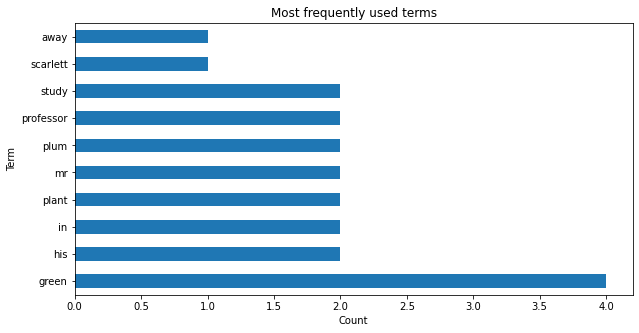

In [9]:
terms = count_vect.get_feature_names_out()
total_counts = counts.sum(axis=0)

df_counts = pd.DataFrame()
df_counts['term'] = terms
df_counts['count'] = total_counts
df_counts = df_counts.sort_values(by='count', ascending=False)

# Just keep the top 10
df_counts = df_counts.iloc[:10]

df_counts.plot(y='count', x='term', kind='barh', legend=None, figsize=(10, 5))
plt.xlabel('Count')
plt.ylabel('Term')
plt.title('Most frequently used terms')
plt.show()


### TF-IDF Scores
We generally get better results using TF-IDF scores than using simple counts as features.

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
sparse_tfidf = tfidf_transformer.fit_transform(counts)
tfidf = np.asarray(sparse_tfidf.todense())
tfidf

array([[0.        , 0.24579517, 0.24579517, 0.24579517, 0.        ,
        0.29034117, 0.        , 0.        , 0.        , 0.18693356,
        0.24579517, 0.24579517, 0.        , 0.        , 0.49159033,
        0.24579517, 0.24579517, 0.24579517, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.18693356, 0.24579517,
        0.        , 0.        , 0.        , 0.        , 0.24579517],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.26903992, 0.45552418, 0.        , 0.34643788, 0.34643788,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.34643788,
        0.34643788, 0.34643788, 0.        , 0.34643788, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.27054288, 0.        , 0.        , 0.        , 0.27054288,
        0.15978698, 0.        , 0.27054288, 0.20575483, 0.        ,
        0.        , 0.        , 0.27054288, 0.

In [11]:
feat_idx = 5
feat_name = count_vect.get_feature_names_out()[feat_idx]
print('TFIDF for feature:', feat_name)

tfidf[:, feat_idx]

TFIDF for feature: green


array([0.29034117, 0.26903992, 0.15978698])

We can display the TF-IDF feature vectors as a heatmap to get a feel for patterns in the data.

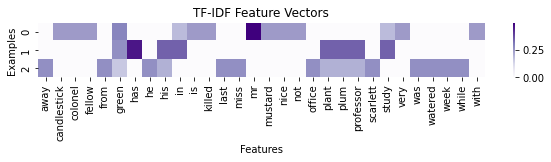

In [12]:
# Display feature vectors as a heatmap
plt.figure(figsize=(10, 1))
sns.heatmap(tfidf, square=False, annot=False, cbar=True, cmap="Purples",
            xticklabels=count_vect.get_feature_names_out())

plt.xticks(rotation=90) 
plt.xlabel('Features')
plt.ylabel('Examples')
plt.title('TF-IDF Feature Vectors')
plt.show()

## Finding similar documents
We can build a nearest neighbors model (NOT a classifier) to find similar documents among the training examples for a given new example.

In [13]:
# Let's make up a new example. (Note that wrapping the string in square brackets
# makes it a Python list of size 1.)
new_example = ["Miss Scarlett and Colonel Mustard have a son named Mr. Orange. He likes to study in the study."]
new_example

['Miss Scarlett and Colonel Mustard have a son named Mr. Orange. He likes to study in the study.']

In [14]:
# We use our same transformers that have been fit to the data.
# This is important because the tfidf scores in a feature vector need to refer
# to the same terms in order to compare two vectors (documents).
new_counts = count_vect.transform(new_example)
print('New feature counts:\n', new_counts.todense())
new_tfidf = tfidf_transformer.transform(new_counts)
new_tfidf = np.asarray(new_tfidf.todense())
print('\nNew TF-IDF scores:')
new_tfidf

New feature counts:
 [[0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 2 0 0 0 0 0 0]]

New TF-IDF scores:


array([[0.        , 0.        , 0.33535157, 0.        , 0.        ,
        0.        , 0.        , 0.33535157, 0.        , 0.25504351,
        0.        , 0.        , 0.        , 0.33535157, 0.33535157,
        0.33535157, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.33535157, 0.51008702, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [15]:
# Find the highest valued feature
idx = np.argmax(new_tfidf)
feat = count_vect.get_feature_names_out()[idx]
print('Highest valued feature: {}, TF-IDF score: {:.2f}'.format(feat, new_tfidf[0, idx]))

Highest valued feature: study, TF-IDF score: 0.51


In [16]:
# Build model to return nearest neighbors
# (Not a classifier)
from sklearn.neighbors import NearestNeighbors

# Create the KNN model
# Since we want to compare sparse feature vectors, we use cosine distance.
knn = NearestNeighbors(n_neighbors=3, algorithm='brute', metric='cosine')

# Fit the model to the TF-IDF feature vectors
model = knn.fit(tfidf)
model

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [17]:
distance, neighbor_idx = model.kneighbors(new_tfidf)

print('Distances to neighbors:\n', distance)

print('\nNeighbor index:')
neighbor_idx

Distances to neighbors:
 [[0.52726025 0.72781907 0.7349298 ]]

Neighbor index:


array([[0, 2, 1]])

In [18]:
# Notice that the distances are a list of lists (two sets of square brackets).
# We can iterate through the neighbors like this (using [0] to get rid of the 
# outer set of brackets):
print(f'Showing documents in order of similarity to \n{new_example}:\n')
for i in neighbor_idx[0]:
  print(i, df['doc_text'].iloc[i])

Showing documents in order of similarity to 
['Miss Scarlett and Colonel Mustard have a son named Mr. Orange. He likes to study in the study.']:

0 Mr. Green killed Colonel Mustard in the study with the candlestick. Mr. Green is not a very nice fellow.
2 Miss Scarlett watered Professor Plum's green plant while he was away from his office last week.
1 Professor Plum has a green plant in his study.
